![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# XAI in deep learning-based image analysis: Explain CNNs

---

In this tutorial, we are going to compare different explainability methods for image classification performed with CNNs. We will:
- Apply Grad-CAM on a new image
- Use the SHAP library to get the SHAP values on the same image
- Compare the two methods
- Discuss the limitation of XAI for CNNs

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your own machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button. This will open this page in the Colab environment, and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/Juelich-2024/xai-for-cnn/Tutorial_XAI_for_ImageAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive, and you can navigate it through the lefthand panel in Colab. You might also have received an email that informs you about the access on your Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive
!git clone --branch Juelich-2024 https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
%cd XAI-Tutorials/xai-for-cnn
%pip install shap==0.41
%pip install lime

### Imports

Let's start with importing all required Python packages.

In [1]:
# Load the required packages
import json
import numpy as np
import matplotlib.pyplot as plt
import utils

import shap

from lime import lime_image
from skimage.segmentation import mark_boundaries
import torch
from torchvision import models, datasets
from torchvision.models.inception import Inception_V3_Weights
# add Grad-CAM model to path
import sys  
sys.path.append('../data_and_models/')
from model_gradcam import GradCamModel

We fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [2]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

## Data and Model Loading

We first load the image we want to analyse and the model we use for predicton.

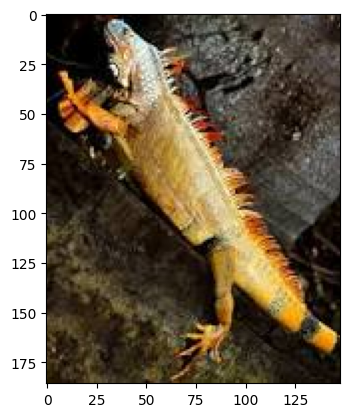

In [3]:
# read and visualize the image
path_to_img = '../data_and_models/images/Iguana.jpeg'
img = utils.read_img(path_to_img)
plt.imshow(img)
plt.show()

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

Before we can use the image, we need to convert the image to RGB channel, transform the image (convert to PIL format, resize to lower resolution, convert to tensor dtype and normalize the pixel values), and unsqueeze the image to add a batch dimension.

In [4]:
# define the transformations (here we are using the ImageNet transformations)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

img_trans = utils.transform_img(img, mean, std)

We define a CNNs model that we will use for the classification using the ResNet50 architecture.

In [5]:
# load model
model_shap = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).eval()
model_lime = models.inception_v3(weights=Inception_V3_Weights.DEFAULT)
model_gc = GradCamModel().eval()

## Now, what are our possibilities to explain the classification of our image?

There are two main kinds of explainability methods for images:

- occlusion- or perturbation-based methods
- gradient-based methods

The first ones consist of manipulating/masking parts of the image to generate explanations. Some examples of these are LIME and SHAP.
The second one consists of leveraging the gradient of the function so that a mapping of the function value onto multiple input dimensions is readily obtained. There are many gradient-based methods (e.g. Grad-CAM, Integrated Gradients, SmoothGradthat), which differ in how these gradients are computed.

In this tutorial, we will compare the results from Grad-CAM with the SHAP library, which combines perturbation- and gradient-based methods.

### Interpretation with SHAP

In the [Tutorial_SHAP_Images.ipynb](../xai-model-agnostic/Tutorial_SHAP_Images.ipynb) notebook you were introduced to the model-agnostic SHAP method. Recall, with SHAP we get contrastive explanations that compare the prediction with the baseline. 

*Note: it can take some time to compute the SHAP values.*

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


(1, 1024, 14, 14)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


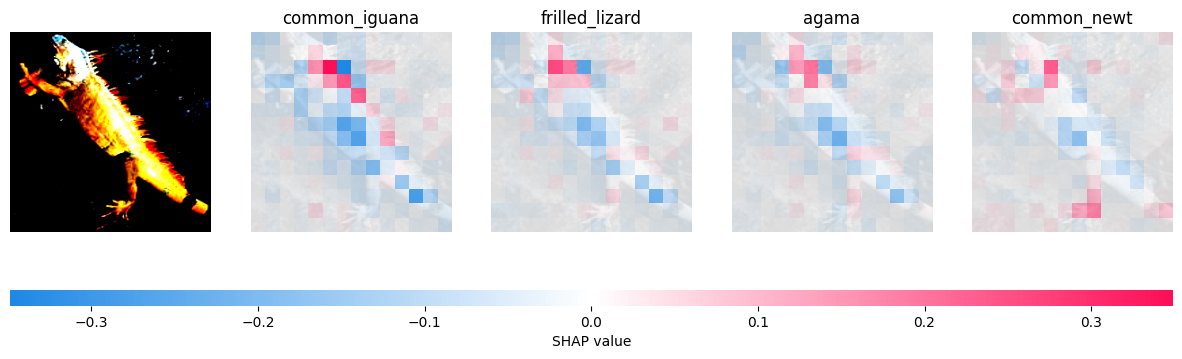

In [6]:
# run SHAP

# Step 1. Select the background dataset for the baseline
X, y = shap.datasets.imagenet50()

# Step 2. Instantiate the explainer class
explainer = shap.GradientExplainer((model_shap, model_shap.layer4), utils.normalize_and_adjust_axes(X, mean, std))

# Step 3. Compute SHAP values on custom image
shap_values, indexes = explainer.shap_values(img_trans, ranked_outputs=4)
print(shap_values[0].shape)

# Step 4. Plot results
# Get class names
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
# Transform image for plotting
img_explained_to_plot = utils.transform_img(img, mean, std, False)
# Plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values] # unroll the axes
shap.image_plot(shap_values, img_explained_to_plot, index_names)

<font color='green'>

#### Question 1: Does the explanation make sense to you? What do you observe? If you don't know these species, check out on the web the images for the different classes

<font color='grey'>

#### Your Answer: 


## Interpretation with LIME
In the [Tutorial_LIME_Images.ipynb](https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/Juelich-2023/data_and_models/data_breastcancer_preprocessed.joblib) we discussed how to use the LIME local interpretation method to explain the outcome of an image classification CNN model.
This model uses a surrogate model trained on interpretable features obtained by perturbing the original image. Let's apply this method to our iguana image and comment on the explanations we get.

  0%|          | 0/1000 [00:00<?, ?it/s]

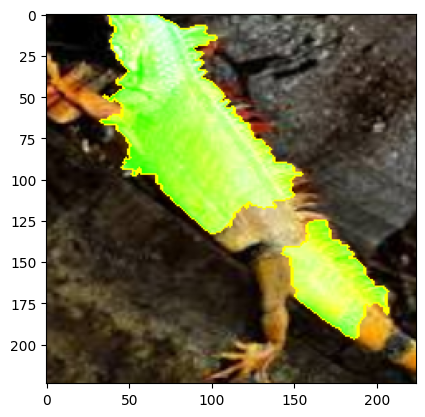

In [7]:
# run LIME

# Step 1. Trasform image for LIME
img = utils.read_image(path_to_img)
pill_transf = utils.get_pil_transform()
preprocess_transform = utils.get_preprocess_transform()

# Step 2. Instantiate the explainer class
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         lambda images: utils.batch_predict(images, model_lime), 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification fun

# Step 3. Get and plot explanations
label_to_explain = 0
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[label_to_explain],
    positive_only=False,
    negative_only=False,
    num_features=5,
    hide_rest=False,)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

As an extra exercise, look at the other top predicted classes for this image, check the explanation for these other classes (repeat step 3 for different labels), and see if the explanation LIME provides is good or not.

In [8]:
# Print top 5 classes and respective probabilities
prediction = utils.batch_predict([pill_transf(img)], model_lime)
top_classes = prediction.argsort()[0, -5:][::-1] 
top_probabilities = prediction[0, top_classes]

for class_label, probability in zip(top_classes, top_probabilities):
    print(f"Class number {class_label} - Probability = {probability:.4f}")

Class number 39 - Probability = 1.0000
Class number 401 - Probability = 0.0000
Class number 46 - Probability = 0.0000
Class number 43 - Probability = 0.0000
Class number 122 - Probability = 0.0000


### Interpretation with GradCAM

In the [Tutorial_GradCAM.ipynb](https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/xai-model-specific/Tutorial_GRADCAM.ipynb) notebook you were introduced to the model-specific Grad-CAM method. This method uses the gradients to localize the pixel in the image that are relevant for the classification, creating a heatmap that is very easy to interpret.

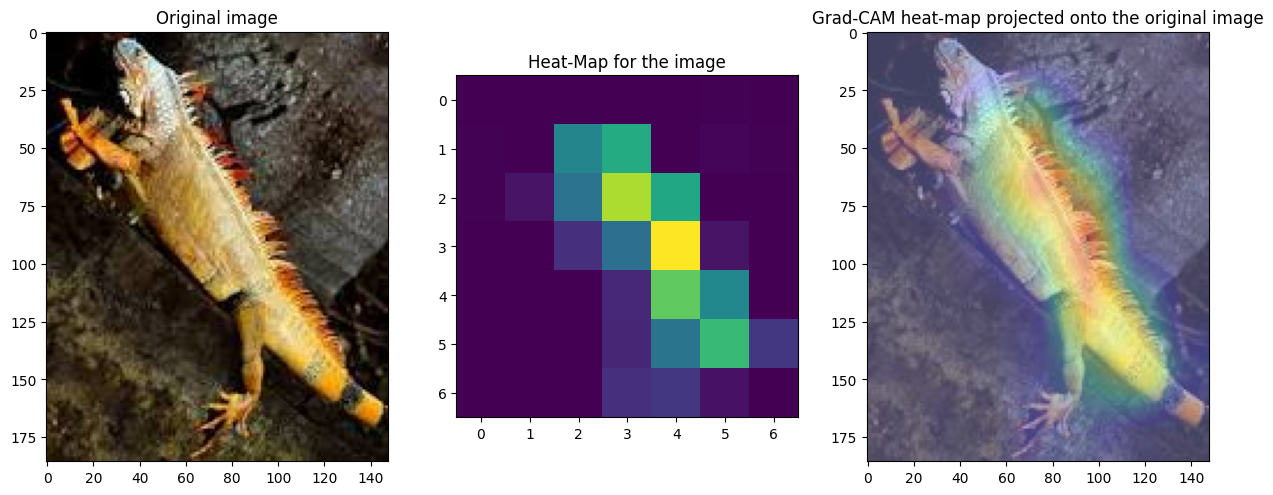

In [10]:
# run grad-cam

# forward pass
out = model_gc(img_trans) 
pred = out.argmax(dim=1)

# calculate and plot heatmap
localization_map = utils.calculate_localization_map(model_gc, img_trans, out, c=pred.item())
heatmap = utils.convert_to_heatmap(localization_map, np.array(img))

# plot results
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(img)
plt.title('Original image')
plt.subplot(132)
plt.imshow(localization_map.squeeze())
plt.title('Heat-Map for the image')
plt.subplot(133)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.imshow(img, alpha=0.5)
plt.title('Grad-CAM heat-map projected onto the original image')
plt.show()

## Comparing Grad-CAM and SHAP

<font color='green'>

#### Exercise: Think about the difference between the two explainability methods for images that we introduced. Discuss and complete the table together with your team
<font color='grey'>

| **Aspect**                | **Grad-CAM**                             | **SHAP**   | **LIME** |
|---------------------------|-----------------------------------------|--------------------------------------------|-----------------|
| **Methodology**      |  |  | |
| **Model Compatibility**   |  |  | |
| **Stability**       |  |  | |
| **Computational Cost**  |  |  | |
| **Baseline Choise**            |  |  | |
| **Global vs local**                |  |  | |


<font color='grey'>

#### Your Answer: 


## Limitations of XAI for images

In this section, we want to collect some examples of the limitations of methods, to underline that it's important to use XAI methods, but we cannot trust them blindly. Among several works, we selected three paper that we advise you to read.

- **Relevance and resistance of saliency maps**: According to the paper ["Overlooked Trustworthiness of Saliency Maps
"](https://link.springer.com/chapter/10.1007/978-3-031-16437-8_43) from Zhang et al., 2022, these two parameters of saliency maps should be taken into consideration in future works to validate the trustworthiness of medical AI explainability. Indeed, as shown in the picture below,it might happen that different predictions might have similar or same saliency map (lack of relevance) or that same predictions might have different saliency maps (lack of resistance).

<center><img src="../docs/source/_figures/relevance_resistance.png" width="600" /></center>

- **Saliency Map can be misleading**: In the paper ["Stop Explaining Black Box Models for High Stakes Decisions and Use Interpretable Models Instead](https://arxiv.org/abs/1811.10154)" (Rudin, 2018) the author underlines how saliency maps are often considered to be explanatory. Saliency maps can be useful to determine what part of the image is being omitted by the classifier, but this leaves out all information about how relevant information is being used. Knowing where the network is looking within the image does not tell the user what it is doing with that part of the image, as illustrated in the figure below. In fact, the saliency maps for multiple classes could be essentially the same; in that case, the explanation for why the image might contain a Siberian husky would be the same as the explanation for why the image might contain a transverse flute.
  
<center><img src="../docs/source/_figures/Husky.png" width="800" /></center>

- **Disagreement Problem**: As shown in the paper ["The Disagreement Problem in Explainable Machine Learning: A Practitioner’s Perspective"](https://arxiv.org/abs/2202.01602)  (Krishna et al., 2022) different models could bring to a different explanation, and it's important to question which one we should consider more reliable for our task at hand.

<center><img src="../docs/source/_figures/comparison.png" width="800" /></center>

## Adversarial attacks & Explainability Methods

### Adversarial Attacks

An **adversarial attack** ([Goodfellow et al., 2014](https://arxiv.org/abs/1406.2661)) consists of subtly modifying an original image in such a way that the changes are almost undetectable to the human eye. The modified image is called an adversarial image, and when submitted to a classifier is misclassified, while the original one is correctly classified.

<center><img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*PmCgcjO3sr3CPPaCpy5Fgw.png" width="800" /></center>

[Image credit](https://arxiv.org/abs/1412.6572)

<font color='green'>

#### Question 2: Can you think about some situations where these adversarial attacks could be very dangerous?

<font color='grey'>

#### Your Answer: 


---
Deep Neural Networks (DNNs) and Convolutional Neural Networks (CNNs), while being the cutting-edge algorithms for numerous imaging tasks, pose a challenge. These black-box models, despite their remarkable accomplishments, are not suitable for handling sensitive and critical tasks discussed earlier. To effectively implement them in these domains, addressing the fragility of these black-box models against adversarial attacks is imperative.

### XAI as a defense strategy

As shown in the figure below [Klawikowska et al., 2020](https://link.springer.com/chapter/10.1007/978-3-030-61401-0_14) the predicted class can change after an adversarial attack, but using explainability heatmaps can help to detect the reason for the misclassification. The upper row contains the input images that are given to the input of the neural network, while the lower row depicts the corresponding heatmaps.
In panel a), we observe the original image where a Deep Neural Network (DNN) correctly classifies it as a cat with high accuracy. In columns b) and d), we notice the differences in the maps after adversarial attacks (Fast Gradient Sign Method (FGSM) and pixel-level attacks), leading to incorrect predictions. In the first case, the colors of the maps are flipped (and thus the pixel significance), and in the second case, it is clearly visible that the network is focusing its attention on this single, adverse pixel.

The paper introduces an adversarial retraining strategy (results are shown in columns c) and e)) that significantly improves results by enabling the correct classification despite the adversarial attacks.

<center><img src="../docs/source/_figures/adversarial_attacks_and_xai.png" width="800" /></center>

### Adversarial attacks for XAI methods robustness

While our focus has been on the application of XAI methods for detecting adversarial attacks, an emerging and promising research area takes a different perspective: investigating the use of adversarial attacks as a means to evaluate the robustness of XAI methods.

We cannot go into the details, but if you're curious, we suggest beginning your exploration with this survey [Banieckil et al., 2022](https://arxiv.org/pdf/2306.06123.pdf).

---
Congratulations! You completed this tutorial.